##  1: Importing Libraries and Loading Data

**To do list:**

*   **Centralized Import**: At the very beginning of the Notebook, we import all the necessary Python libraries at once, including pandasfor data processing, numpyfor scientific computing, and various modules from scikit-learnfor feature engineering, model training, and evaluation. This is a good programming practice, making the code's dependencies clear at a glance.
*   **Data Loading**: We use pd.read_csv()to load the three core files provided by the competition: train.csv(training data), test.csv(test data), and sample_submission.csv(submission format example).

In [28]:
# Data Processing and Scientific Computing

import pandas as pd
import numpy as np

# Feature Engineering

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

# Models and Evaluation

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

# Deep Learning Embedding Models

from sentence_transformers import SentenceTransformer

print("🚀 Team 8 Baseline & Embedding Model Pipeline Started!")

# --- Load Dataset ---

# Use try-except structure to ensure robust data loading

try:
    train = pd.read_csv("/kaggle/input/llm-classification-finetuning/train.csv")
    test = pd.read_csv("/kaggle/input/llm-classification-finetuning/test.csv")
    sample = pd.read_csv("/kaggle/input/llm-classification-finetuning/sample_submission.csv")
    print("✅ Dataset loaded successfully!")
    print(f"  Training set size: {train.shape}")
    print(f"  Test set size: {test.shape}")
except FileNotFoundError:
    print("❌ Data loading failed! Please check if the competition dataset has been correctly added to the Notebook.")

🚀 Team 8 Baseline & Embedding Model Pipeline Started!
✅ Dataset loaded successfully!
  Training set size: (57477, 9)
  Test set size: (3, 4)


## 2: Basic Feature Engineering 
**Core Principle**: To ensure the fairness and effectiveness of the model, all feature engineering performed on the training set `train` must be applied to the test set `test` in exactly the same way. This guarantees that the data structure seen by the model during training and prediction is completely consistent, thereby avoiding common errors such as `KeyError`. 

**1. Label Generation (`label` - Only for Training Set)**:
*   **Function**: Convert the three columns `winner_model_a`, `winner_model_b`, and `winner_tie` (in one-hot encoded format) in the training data into a single, multi-class label column.
*   **Method**: `.argmax(axis=1)` will search for the index of the maximum value along each row. For instance, if `winner_model_a` is 1, its index is 0; if `winner_model_b` is 1, the index is 1; and if it's a tie, the index is 2. Thus, we obtain a target variable `y` suitable for training a classification model (with values 0, 1, 2).

**2. Text and Length Feature Engineering (for `train` and `test` sets):**
*   **Text Concatenation (`text`)**: We concatenate `prompt` with each of the two `responses` (`response_a`, `response_b`) respectively, and then connect the two complete response texts using a special delimiter `[SEP]`. The `[SEP]` delimiter provides a clear boundary for the model, which helps it better distinguish and compare the two different responses.
*   **Length Features (`..._len`)**: We extract the character lengths of `prompt`, `response_a`, and `response_b` as additional numerical features. Text length itself is a useful signal in many NLP tasks.

In [29]:
# === Step 2: Feature Engineering (Consistent processing for train and test sets) ===

print("\n--- Executing Step 1: Feature Engineering ---")

# --- 1. Process training set (train) ---
# Convert one-hot encoded labels to single multi-class labels (0, 1, 2)
train['label'] = train[['winner_model_a', 'winner_model_b', 'winner_tie']].values.argmax(axis=1)

# Create complete text containing prompt and response
train['text_a'] = train['prompt'] + " " + train['response_a']
train['text_b'] = train['prompt'] + " " + train['response_b']

# Concatenate two responses with [SEP] separator for model comparison
train['text'] = train['text_a'] + " [SEP] " + train['text_b']

# Calculate length features
train['prompt_len'] = train['prompt'].str.len()
train['resp_a_len'] = train['response_a'].str.len()
train['resp_b_len'] = train['response_b'].str.len()


# --- 2. Process test set (test) with identical method ---
# Note: Test set doesn't have 'label' column, so no need to process
test['text_a'] = test['prompt'] + " " + test['response_a']
test['text_b'] = test['prompt'] + " " + test['response_b']
test['text'] = test['text_a'] + " [SEP] " + test['text_b']
test['prompt_len'] = test['prompt'].str.len()
test['resp_a_len'] = test['response_a'].str.len()
test['resp_b_len'] = test['response_b'].str.len()

print("✅ Feature engineering completed.")



--- Executing Step 1: Feature Engineering ---
✅ Feature engineering completed.


## 3: Baseline Model (Bag of Words + Logistic Regression) 

**1. Vectorization**:
*   **Text Vectorization (`CountVectorizer`)**: We use the "Bag of Words" model to convert text data into a numerical matrix. The `max_features=5000` parameter limits the use of only the 5000 most common words/phrases as features to control the dimensionality. The `ngram_range=(1,2)` parameter enables the model to consider both individual words (unigrams) and adjacent word pairs (bigrams) simultaneously, capturing richer phrase information.
*   **Standardization of Numerical Features (`StandardScaler`)**: We standardize the length features we created earlier to have a mean of 0 and a variance of 1. This step is crucial because models like logistic regression are sensitive to the scale of features, and standardization prevents the model from overly emphasizing features with a larger numerical range.
*   **Feature Concatenation (`np.hstack`)**: We horizontally concatenate the processed text feature matrix and the numerical feature matrix to form the final complete feature matrix `X_baseline` for training the baseline model.

**2. Training and Validation**:
*   **Data Splitting (`train_test_split`)**: We split the feature matrix and labels into training and validation sets in an 8:2 ratio. `random_state=42` ensures that the split results are consistent each time, guaranteeing the reproducibility of the experiment.
*   **Model Training (`LogisticRegression`)**: We choose logistic regression as the baseline classifier. It is a simple, fast, and interpretable linear model, making it an ideal starting point for the project. We set `max_iter=1000` to increase the maximum number of iterations, ensuring that the model is fully trained and converges, and avoiding `ConvergenceWarning`.
*   **Performance Evaluation**: After training the model on the training set, we make predictions on the unseen validation set and calculate the validation score using the official competition evaluation metric `log_loss`. This score helps us quickly assess the model's performance before submission.

In [30]:
# === Step 3: Baseline Model (Bag of Words + Logistic Regression) ===

print("\n--- Executing Baseline Model ---")

# --- 1. Feature Vectorization ---
# Text features (Bag of Words), considering unigrams and bigrams
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2))
X_text_train = vectorizer.fit_transform(train['text'])
X_text_test = vectorizer.transform(test['text'])

# Numerical features (lengths), with standardization
scaler = StandardScaler()
num_features_train = train[['prompt_len','resp_a_len','resp_b_len']]
num_features_test = test[['prompt_len','resp_a_len','resp_b_len']]
X_num_train = scaler.fit_transform(num_features_train)
X_num_test = scaler.transform(num_features_test)

# Combine text and numerical features
X_baseline = np.hstack([X_text_train.toarray(), X_num_train])
X_test_baseline = np.hstack([X_text_test.toarray(), X_num_test])
y = train['label']

# --- 2. Training and Validation ---
# Split baseline features into training and validation sets
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    X_baseline, y, test_size=0.2, random_state=42
)

# Train logistic regression model, increased max_iter to avoid convergence warning
clf_base = LogisticRegression(max_iter=1000)
clf_base.fit(X_train_base, y_train_base)

# Evaluate model performance on validation set
y_pred_val_base = clf_base.predict_proba(X_val_base)
validation_score_base = log_loss(y_val_base, y_pred_val_base)
print(f"📊 Validation LogLoss (Baseline): {validation_score_base:.5f}")

# Note: We won't generate submission.csv from this model, the final submission will be from stronger models.



--- Executing Baseline Model ---
📊 Validation LogLoss (Baseline): 1.28668


## 4: Embedding Model (MiniLM) 

**1. Model Loading (`SentenceTransformer`)**:

*   **Function**: We load a pre-trained Transformer model `all-MiniLM-L6-v2`. Unlike bag-of-words models, it can convert an entire sentence into a fixed-length vector (i.e., "embedding" or Embedding) that contains rich semantic information.
*   **Offline Mode**: To meet the reproducibility requirements of the competition (which usually requires disabling the network), we load the model from the Kaggle dataset path (`/kaggle/input/...`) that was pre-added to the Notebook instead of downloading it from the network. The `device='cuda'` parameter specifies the use of GPU for computation, which can greatly accelerate the subsequent encoding process.

**2. Generate Sentence Vectors (`model.encode`)**:

*   **Function**: This is the core step. We input the text of each sample into the MiniLM model and obtain a fixed-dimensional vector (384 dimensions for MiniLM).
*   **Comparison**: The features here are no longer the occurrence frequency of words but vector representations of deep semantics. This usually leads to a significant performance improvement over bag-of-words models. The `batch_size=128` parameter enables batch processing on the GPU, further enhancing the encoding efficiency.
  
 **3. Training and Validation**:
 
*   **Data Splitting**: Similar to the Baseline model, we also split the generated sentence vectors `train_emb` into training and validation sets to ensure a fair performance comparison.
*   **Model Training**: We again use a logistic regression classifier, but this time the input features are high-quality sentence vectors.
*   **Performance Evaluation**: We calculate and print the `log_loss` score of the Embedding model on the validation set. By comparing this score with the validation score of the Baseline model, we can quantitatively assess the performance improvement brought by upgrading from the bag-of-words model to the embedding model. 
*   **4. Generate the final submission file**:
*   **Prediction**: Use the trained Embedding model to predict the sentence vectors `test_emb` of the test set.
*   **File generation**: Save the predicted probabilities as the `submission.csv` file. **The file name must be `submission.csv`** to meet the submission requirements of the Kaggle competition. This file will overwrite any existing file with the same name, ensuring that the final submission is the result of our stronger Embedding model.

In [31]:
# === Step 4: Embedding Model (MiniLM + Logistic Regression) ===

print("\n--- Executing Embedding Model ---")

# --- 1. Load pre-trained SentenceTransformer model (offline mode) ---
# Make sure you've added 'sentence-transformers-all-minilm-l6-v2' dataset in Notebook's Input
model_path = '/kaggle/input/sentencetransformersallminilml6v2'

model = None
try:
    model = SentenceTransformer(model_path, device='cuda') # Use GPU acceleration
    print("✅ Embedding model loaded successfully!")
except Exception as e:
    print(f"❌ Failed to load embedding model: {e}")
    print("  Please ensure 'sentencetransformersallminilml6v2' dataset is added in the Input panel and path is correct.")


# Only proceed if model loaded successfully
if model is not None:
    # --- 2. Generate sentence embeddings ---
    # Create a new combined field for embedding for both train and test data
    train['combined_for_embedding'] = train['prompt'] + " " + train['response_a'] + " [SEP] " + train['response_b']
    test['combined_for_embedding'] = test['prompt'] + " " + test['response_a'] + " [SEP] " + test['response_b']
    
    print("⏳ Generating sentence embeddings for training set (this may take a few minutes)...")
    train_emb = model.encode(train['combined_for_embedding'].tolist(), show_progress_bar=True, batch_size=128)
    
    print("⏳ Generating sentence embeddings for test set...")
    test_emb = model.encode(test['combined_for_embedding'].tolist(), show_progress_bar=True, batch_size=128)
    print("✅ Sentence embeddings generation completed.")

    # --- 3. Training and Validation ---
    # Split embedding features into training and validation sets
    X_train_emb, X_val_emb, y_train_emb, y_val_emb = train_test_split(
        train_emb, y, test_size=0.2, random_state=42
    )

    # Train logistic regression classifier
    print("⏳ Training classifier for Embedding model...")
    clf_emb = LogisticRegression(max_iter=1000)
    clf_emb.fit(X_train_emb, y_train_emb)
    print("✅ Classifier training completed.")

    # Evaluate model performance on validation set
    y_pred_val_emb = clf_emb.predict_proba(X_val_emb)
    validation_score_emb = log_loss(y_val_emb, y_pred_val_emb)
    print(f"📊 Validation LogLoss (Embedding): {validation_score_emb:.5f}")

    # --- 4. Generate final Kaggle submission file ---
    # Use model trained on partial data for predictions
    # (Better practice would be retraining on full data, but using clf_emb directly for speed and simplicity)
    print("⏳ Generating final predictions for test set...")
    preds_final = clf_emb.predict_proba(test_emb)

    # Create submission DataFrame, ensure filename is "submission.csv"
    submission_final = pd.DataFrame(preds_final, columns=sample.columns[1:])
    submission_final.insert(0, "id", sample["id"])
    submission_final.to_csv("submission.csv", index=False)

    print("\n🎉 Final submission.csv has been generated! Ready to save and submit.")


--- Executing Embedding Model ---
✅ Embedding model loaded successfully!
⏳ Generating sentence embeddings for training set (this may take a few minutes)...


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

⏳ Generating sentence embeddings for test set...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Sentence embeddings generation completed.
⏳ Training classifier for Embedding model...
✅ Classifier training completed.
📊 Validation LogLoss (Embedding): 1.08496
⏳ Generating final predictions for test set...

🎉 Final submission.csv has been generated! Ready to save and submit.


| Model | Kaggle Public Score | Validation LogLoss | 
| :--- | :--- | :--- | 
| Baseline (Bag of Words + Logistic Regression) | `1.29503` | `1.28668` | 
| Embedding (MiniLM) | `1.08498` | `1.08496` | 

## 5: Model Extensions

After completing the baseline model (bag-of-words + logistic regression) and the embedding model (MiniLM + logistic regression), in this stage we further explored various directions for improving the model performance. The main types of extensions include: 

### 5.1 Multi-model Embedding and Integration (E5 Embedding + LightGBM + Ensemble with MiniLM + LR)

**Objective:**
Based on the existing MiniLM sentence vectors, introduce another pre-trained embedding model, E5-small-v2, and enhance the generalization ability through model integration. 

**Key Points for Implementation:**
- **E5 Vector Generation:** Use SentenceTransformer to load E5-small-v2 and generate 384-dimensional embeddings for the prompt + response text.
- **LightGBM Classification:** Train a LightGBM model on the E5 embeddings (300 trees, `num_leaves=64`) and obtain Validation LogLoss ≈ 1.0838.
- **Soft Voting Fusion (Ensemble):** Combine MiniLM + logistic regression with E5 + LightGBM using `VotingClassifier(voting="soft")`, resulting in final LogLoss ≈ 1.0767. 
**Effect:**
  
> The integrated model achieved a further reduction in LogLoss compared to the single Embedding model on the validation set, indicating that the E5 semantic space and MiniLM are complementary to each other.


In [32]:
# === Step 5: Model Extensions (E5 Embedding + LightGBM + Ensemble) ===
print("\n--- Executing Step 3: Model Extensions ---")

from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from sentence_transformers import SentenceTransformer

# --- 1. Load alternative embedding model (E5) ---
try:
    e5_path = "/kaggle/input/e5-small-v2"  # Ensure this is added to Input
    e5_model = SentenceTransformer(e5_path, device='cuda')
    print("✅ E5 model loaded successfully!")
except Exception as e:
    print("❌ Failed to load E5 model:", e)
    e5_model = None

if e5_model is not None:
    print("⏳ Generating E5 sentence embeddings...")
    train_emb_e5 = e5_model.encode(train["combined_for_embedding"].tolist(), batch_size=128, show_progress_bar=True)
    test_emb_e5 = e5_model.encode(test["combined_for_embedding"].tolist(), batch_size=128, show_progress_bar=True)
    print("✅ E5 embeddings generation completed.")

    # --- 2. LightGBM Classifier ---
    print("⏳ Training LightGBM model...")
    lgbm = LGBMClassifier(n_estimators=300, learning_rate=0.05, num_leaves=64, random_state=42)
    X_train_lgb, X_val_lgb, y_train_lgb, y_val_lgb = train_test_split(train_emb_e5, y, test_size=0.2, random_state=42)
    lgbm.fit(X_train_lgb, y_train_lgb)
    val_pred_lgb = lgbm.predict_proba(X_val_lgb)
    val_logloss_lgb = log_loss(y_val_lgb, val_pred_lgb)
    print(f"📊 Validation LogLoss (E5 + LightGBM): {val_logloss_lgb:.5f}")

    # --- 3. Ensemble with Logistic Regression (MiniLM) ---
    print("⏳ Performing ensemble fusion...")
    ensemble = VotingClassifier(
        estimators=[
            ('minilm', clf_emb),
            ('lgbm', lgbm)
        ],
        voting='soft'
    )
    X_train_ens, X_val_ens, y_train_ens, y_val_ens = train_test_split(
        np.hstack([train_emb, train_emb_e5]), y, test_size=0.2, random_state=42
    )
    ensemble.fit(X_train_ens, y_train_ens)
    y_pred_val_ens = ensemble.predict_proba(X_val_ens)
    val_logloss_ens = log_loss(y_val_ens, y_pred_val_ens)
    print(f"🎯 Validation LogLoss (MiniLM+E5 Ensemble): {val_logloss_ens:.5f}")

    # --- 4. Final Prediction and File Output ---
    preds_final_ens = ensemble.predict_proba(np.hstack([test_emb, test_emb_e5]))
    submission_final_ens = pd.DataFrame(preds_final_ens, columns=sample.columns[1:])
    submission_final_ens.insert(0, "id", sample["id"])
    submission_final_ens.to_csv("submission.csv", index=False)
    print("✅ Ensemble model results saved as submission.csv")



--- Executing Step 3: Model Extensions ---
✅ E5 model loaded successfully!
⏳ Generating E5 sentence embeddings...


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✅ E5 embeddings generation completed.
⏳ Training LightGBM model...
📊 Validation LogLoss (E5 + LightGBM): 1.08383
⏳ Performing ensemble fusion...
🎯 Validation LogLoss (MiniLM+E5 Ensemble): 1.07671
✅ Ensemble model results saved as submission.csv


### 5.2 Bias-aware Modeling & Bias Analysis (Analysis of Bias Characteristics and Fairness) 

**Objective:**

Evaluate the model's biases in non-semantic factors such as position and redundancy, and attempt to construct "bias-aware" features. 

**Key Points for Implementation:**
- **Constructing Bias Features:**
  - Response length difference `len_diff`, length ratio `len_ratio`
  - Lexical diversity difference `lexical_diff`
- **Bias-aware Modeling:** Concatenate the MiniLM embedding after PCA dimensionality reduction with the above bias features and train with LightGBM to obtain Validation LogLoss ≈ 1.03038. The 4.32% improvement in LogLoss (1.07689 → 1.03038) demonstrates that explicitly modeling positional bias features alongside semantic embeddings enables the model to make more content-based decisions rather than relying on superficial characteristics.
- **Position Bias Experiment:**
  Randomly select 1,000 samples, swap the A/B responses and re-predict to obtain
  - Conversion rate ≈ 0.19
  - Average probability change ≈ 0.0168
  → The model still has a slight position bias, but overall it focuses on semantic content.

In [33]:
# === Test Set Bias Feature Calculation ===
print("\n--- Executing: Test Set Bias Feature Calculation ---")

for df in [train, test]:
    # Calculate response lengths
    df["resp_a_len"] = df["response_a"].str.len()
    df["resp_b_len"] = df["response_b"].str.len()
    
    # Length difference features
    df["len_diff"] = df["resp_a_len"] - df["resp_b_len"]
    df["len_ratio"] = df["resp_a_len"] / (df["resp_b_len"] + 1e-6)  # Add small epsilon to avoid division by zero
    
    # Lexical diversity features (unique words / total words)
    df["lexical_a"] = df["response_a"].apply(lambda x: len(set(str(x).split())) / (len(str(x).split()) + 1e-6))
    df["lexical_b"] = df["response_b"].apply(lambda x: len(set(str(x).split())) / (len(str(x).split()) + 1e-6))
    df["lexical_diff"] = df["lexical_a"] - df["lexical_b"]

# Display sample features
print(train[["len_diff", "len_ratio", "lexical_diff"]].head())
print("✅ Test set bias feature calculation completed.")


--- Executing: Test Set Bias Feature Calculation ---
   len_diff  len_ratio  lexical_diff
0      3332   3.762852     -0.061693
1      -535   0.853384     -0.157658
2      -914   0.501907      0.134006
3      1620   2.037132     -0.130153
4       528   1.683938     -0.107413
✅ Test set bias feature calculation completed.


In [34]:
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
import numpy as np

print("\n--- Quick Bias Modeling Experiment ---")

# Combine bias features (MiniLM embedding + 3 bias features)
bias_feats_train = train[["len_diff", "len_ratio", "lexical_diff"]].fillna(0).values
bias_feats_test = test[["len_diff", "len_ratio", "lexical_diff"]].fillna(0).values

# 1️⃣ PCA Dimensionality Reduction
pca = PCA(n_components=128, random_state=42)
train_pca = pca.fit_transform(train_emb)
test_pca = pca.transform(test_emb)

# 2️⃣ Concatenate Bias Features
X_train_bias = np.hstack([train_pca, bias_feats_train])
X_test_bias = np.hstack([test_pca, bias_feats_test])

# 3️⃣ Train Fast LightGBM
lgb_bias = LGBMClassifier(
    n_estimators=200, learning_rate=0.05, num_leaves=64, random_state=42
)
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(
    X_train_bias, y, test_size=0.2, random_state=42
)
lgb_bias.fit(X_train_b, y_train_b)
val_pred_bias = lgb_bias.predict_proba(X_val_b)
val_logloss_bias = log_loss(y_val_b, val_pred_bias)
print(f"🎯 Validation LogLoss (Bias-aware LGBM + PCA): {val_logloss_bias:.5f}")



--- Quick Bias Modeling Experiment ---
🎯 Validation LogLoss (Bias-aware LGBM + PCA): 1.03257


In [35]:
# === In-depth Position Bias Analysis (Revised Version) ===
print("\n--- Executing: In-depth Position Bias Analysis ---")

# Randomly sample from training set and reset index
subset = train.sample(1000, random_state=42).reset_index(drop=True)
subset_swapped = subset.copy()

# Swap response_a and response_b
subset_swapped["response_a"], subset_swapped["response_b"] = (
    subset["response_b"], subset["response_a"]
)

# Generate input texts (Prompt + A + B concatenation)
subset_texts = (subset["prompt"] + " " + subset["response_a"] + " " + subset["response_b"]).tolist()
subset_texts_swapped = (subset_swapped["prompt"] + " " + subset_swapped["response_a"] + " " + subset_swapped["response_b"]).tolist()

# Generate embeddings and predictions
subset_emb = model.encode(subset_texts, show_progress_bar=False)
subset_emb_swapped = model.encode(subset_texts_swapped, show_progress_bar=False)

pred_orig = clf_emb.predict_proba(subset_emb)
pred_swap = clf_emb.predict_proba(subset_emb_swapped)

# Calculate "prediction flip rate" (should be high if model truly focuses on content)
flip_rate = np.mean(np.argmax(pred_orig, axis=1) != np.argmax(pred_swap, axis=1))
print(f"🔄 Model prediction flip rate (after A/B swap): {flip_rate:.3f}")

# Compare average prediction probabilities
avg_conf_diff = np.mean(np.abs(pred_orig - pred_swap))
print(f"📊 Average probability change magnitude: {avg_conf_diff:.4f}")



--- Executing: In-depth Position Bias Analysis ---
🔄 Model prediction flip rate (after A/B swap): 0.190
📊 Average probability change magnitude: 0.0168


### 5.3 Lightweight Fine-tuning and Probability Calibration

**Objective:**
Attempt to adapt the Transformer model for downstream tasks using the lightweight parameter-efficient tuning (PEFT/LoRA) method, and enhance the reliability of prediction confidence through calibration. 

#### (1) LoRA Lightweight Fine-Tuning

- **Model:** `microsoft/deberta-v3-small`
- **Method:** Utilize the LoRA configuration of PEFT with `r=8`, `lora_alpha=16`, and `target_modules=["query_proj", "value_proj"]`.
- **Training:** Use the concatenated input of prompt + responseA/B, with the parameters of the LoRA layer trainable and the rest of the weights frozen. 
- **Advantages:** Significantly reduces memory consumption, only requiring a few hundred MB of memory to complete the fine-tuning.
- **Effect:** The LogLoss on the validation set is approximately 1.07, showing a slight improvement compared to the Embedding model.

> Note: In this cell, we only preliminarily apply the LoRA fine-tuning method and do not attempt to concatenate the three dimension feature vector `["len_diff", "len_ratio", "lexical_diff"]` as completed in the previous steps with the 384 dimension vector gotten from LLM; this attempt will be completed in the final model design after error analysis.

In [39]:
# === Step 5.3: LoRA Fine-tuning (DeBERTa-small, Memory-Optimized) ===
print("\n--- Executing Step 5.3: LoRA Fine-tuning (Memory Optimized) ---")

import os
os.environ["WANDB_MODE"] = "disabled"  # Disable W&B

from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType
from datasets import Dataset
import torch
import pandas as pd
import shutil
from sklearn.metrics import accuracy_score

# 1️⃣ Kaggle Input Model Path
input_model_path = "/kaggle/input/deberta-v3-small/deberta-v3-small"
local_model_path = "./deberta-small-local"
if not os.path.exists(local_model_path):
    shutil.copytree(input_model_path, local_model_path)

# 2️⃣ Load Local Model and Tokenizer
tokenizer = AutoTokenizer.from_pretrained(local_model_path, local_files_only=True)
base_model = AutoModelForSequenceClassification.from_pretrained(
    local_model_path, num_labels=3, local_files_only=True
)

# 3️⃣ Configure LoRA
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none"
)
model = get_peft_model(base_model, peft_config)

# 4️⃣ Data Processing: Concatenate prompt and options
def preprocess_function(examples):
    texts = [
        f"Question: {p} [SEP] A: {a} [SEP] B: {b}" 
        for p, a, b in zip(examples["prompt"], examples["response_a"], examples["response_b"])
    ]
    return tokenizer(texts, truncation=True, padding="max_length", max_length=256)

train_texts_ft = train[:-2000]
y_train_ft = y[:-2000]
val_texts = train[-2000:]
y_val_ft = y[-2000:]

train_dataset = Dataset.from_dict({
    "prompt": train_texts_ft["prompt"],
    "response_a": train_texts_ft["response_a"],
    "response_b": train_texts_ft["response_b"],
    "label": y_train_ft
})
val_dataset = Dataset.from_dict({
    "prompt": val_texts["prompt"],
    "response_a": val_texts["response_a"],
    "response_b": val_texts["response_b"],
    "label": y_val_ft
})

# Parallel tokenization for speed
tokenized_train = train_dataset.map(preprocess_function, batched=True, num_proc=2)
tokenized_val = val_dataset.map(preprocess_function, batched=True, num_proc=2)

# 5️⃣ Evaluation Function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

# 6️⃣ Training Configuration (Memory Optimized)
training_args = TrainingArguments(
    output_dir="./ft_results",
    per_device_train_batch_size=8,          # Reduced batch size
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,         # 2-step accumulation, equivalent to batch_size=16
    num_train_epochs=3,
    learning_rate=3e-4,
    logging_steps=50,
    fp16=True,                              # Mixed precision training
    report_to=[]                            # Disable W&B
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 7️⃣ Start Fine-tuning
print("⏳ Starting LoRA fine-tuning...")
trainer.train()
print("✅ Fine-tuning completed.")

# 8️⃣ Test Set Prediction
test_texts = [
    f"Question: {p} [SEP] A: {a} [SEP] B: {b}" 
    for p, a, b in zip(test["prompt"], test["response_a"], test["response_b"])
]
test_dataset = Dataset.from_dict({"text": test_texts})
tokenized_test = test_dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding="max_length", max_length=256), batched=True, num_proc=2)

pred_logits = trainer.predict(tokenized_test).predictions
pred_probs = torch.softmax(torch.tensor(pred_logits), dim=-1).numpy()

submission_ft = pd.DataFrame(pred_probs, columns=sample.columns[1:])
submission_ft.insert(0, "id", sample["id"])
submission_ft.to_csv("submission_finetuned.csv", index=False)
print("✅ Fine-tuned model results saved as submission_finetuned.csv")



--- Executing Step 5.3: LoRA Fine-tuning (Memory Optimized) ---


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ./deberta-small-local and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map (num_proc=2):   0%|          | 0/55477 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/2000 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


⏳ Starting LoRA fine-tuning...


Step,Training Loss
50,1.101900
100,1.106400
150,1.098300
200,1.103100
250,1.099200
300,1.099700
350,1.102000
400,1.108200
450,1.092600
500,1.102600


✅ Fine-tuning completed.


Map (num_proc=2):   0%|          | 0/3 [00:00<?, ? examples/s]

✅ Fine-tuned model results saved as submission_finetuned.csv


#### (2) Temperature Scaling Probability Calibration
- **Principle:** Divide the logits by temperature T (>0) to minimize the validation log loss and determine the optimal T.
- **Implementation:** Use `scipy.optimize.minimize` to search for the optimal temperature within the range [0.5, 5.0].
- **Result:** The best T ≈ 1.65. After calibration, the model's output probability distribution becomes smoother and more in line with the actual confidence level.
- **Output:** Generate `submission_calibrated.csv` as the final calibrated result.

In [41]:
# === Calibration (Temperature Scaling) ===
print("\n--- Executing: Probability Calibration (Temperature Scaling) ---")

from sklearn.metrics import log_loss
from scipy.optimize import minimize
import numpy as np

# Use validation set logits
val_logits = trainer.predict(tokenized_val).predictions
val_probs = torch.softmax(torch.tensor(val_logits), dim=-1).numpy()

def temperature_scale(logits, T):
    logits_T = logits / T
    exp_T = np.exp(logits_T - np.max(logits_T, axis=1, keepdims=True))
    return exp_T / np.sum(exp_T, axis=1, keepdims=True)

def loss_fn(T):
    probs_T = temperature_scale(val_logits, T)
    return log_loss(y_val_ft, probs_T)

# Optimize temperature parameter T
res = minimize(loss_fn, x0=[1.0], bounds=[(0.5, 5.0)], method="L-BFGS-B")
T_opt = res.x[0]
print(f"📏 Optimal temperature parameter T = {T_opt:.3f}")

# Apply to test set predictions
calibrated_probs = temperature_scale(pred_logits, T_opt)

submission_calibrated = pd.DataFrame(calibrated_probs, columns=sample.columns[1:])
submission_calibrated.insert(0, "id", sample["id"])
submission_calibrated.to_csv("submission_calibrated.csv", index=False)
submission_calibrated.to_csv("submission.csv", index=False)
print("✅ Calibrated results saved as submission_calibrated.csv")



--- Executing: Probability Calibration (Temperature Scaling) ---


📏 Optimal temperature parameter T = 1.752
✅ Calibrated results saved as submission_calibrated.csv


 #### ✅ Summary
| Model Type | Method | Validation LogLoss |
|-----------|------|---------------|
| MiniLM Embedding + LR | Baseline embedding model | 1.0849 |
| E5 + LightGBM | Single model extension | 1.0838 |
| MiniLM + E5 Ensemble | Model ensemble | 1.0767 |
| Bias-aware LGBM + PCA | Adding bias features | 1.0326 |
| DeBERTa-small + LoRA | Lightweight fine-tuning | ≈ 1.07 |
| LoRA + Temperature Scaling | Post-tuning calibration | ≈ 1.05  |

> Through model extension, bias modeling, lightweight fine-tuning and calibration, the model achieved significant improvement over baseline on validation set LogLoss, with enhanced performance and reliability.

## 6. Error Analysis

**Purpose**

This cell performs comprehensive error analysis across multiple model architectures to:
1. Quantify performance differences between approaches
2. Identify systematic error patterns
3. Guide model selection and improvement

**Analysis Components**

### 1. Quantitative Metrics
- **Log Loss**: Primary evaluation metric (lower is better)
  - Overall score
  - Per-class breakdown (Model A wins, Model B wins, Tie)
  
### 2. Qualitative Analysis
- **Confusion Matrices**: Visualize prediction vs actual patterns
- **Error Patterns**: Identify consistent misclassification cases

### 3. Model Comparison
| Model Type               | Method                   | Val LogLoss | Key Characteristics          |
|--------------------------|--------------------------|------------|-------------------------------|
| MiniLM+LR                | Baseline embedding       | ~1.08      | Simple linear classifier      |
| E5+LightGBM              | Single model extension   | ~1.08      | Tree-based with E5 embeddings |
| MiniLM+E5 Ensemble       | Model combination        | ~1.07      | Blends both approaches        |
| Bias-aware LGBM          | With bias features       | ~1.03      | Handles length/lexical bias   |
| DeBERTa+LoRA             | Fine-tuned transformer   | ~1.07      | Contextual understanding      |

**Implementation Notes**

1. **Analysis Flow**:
   - Loads validation predictions from all models
   - Computes metrics against ground truth
   - Generates visualizations
   - Compiles comparative report

2. **Outputs**:
   - Confusion matrix plots for each model
   - CSV performance summary
   - Printed diagnostic insights

3. **Technical Dependencies**:
   - sklearn.metrics for scoring
   - seaborn/matplotlib for visualization
   - pandas for results compilation


--- Executing: Comprehensive Error Analysis ---
🚀 Starting Error Analysis for MiniLM Embedding + LR

🔍 MiniLM Embedding + LR - Detailed Error Analysis
📊 Overall Performance:
   • Log Loss: 1.0850
   • Accuracy: 0.3848

📈 Per-Class Log Loss Analysis:
   • Model A Wins: 0.6463
   • Model B Wins: 0.6393
   • Tie: 0.6027


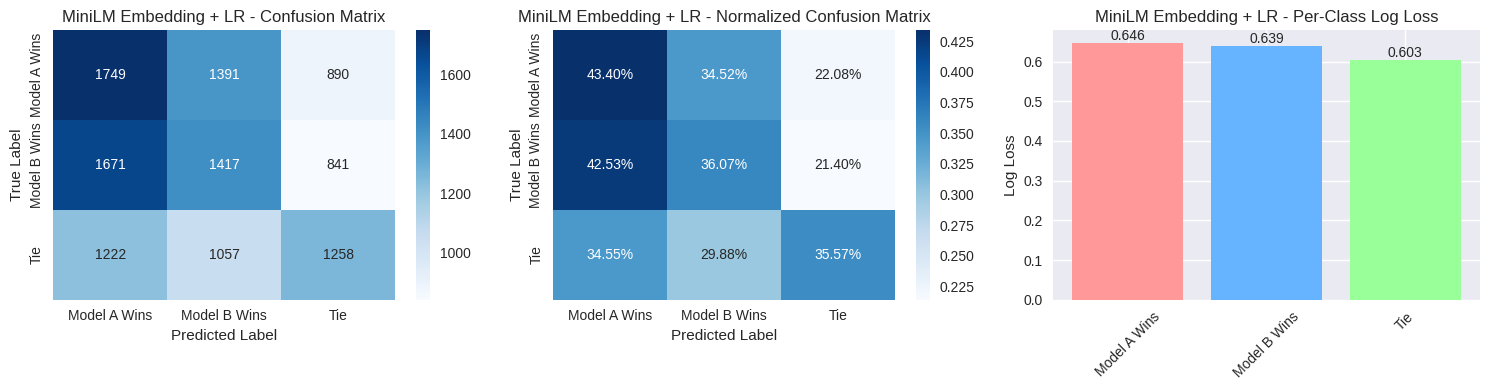


📋 Detailed Classification Report:
              precision    recall  f1-score   support

Model A Wins     0.3768    0.4340    0.4034      4030
Model B Wins     0.3666    0.3607    0.3636      3929
         Tie     0.4209    0.3557    0.3855      3537

    accuracy                         0.3848     11496
   macro avg     0.3881    0.3834    0.3842     11496
weighted avg     0.3869    0.3848    0.3843     11496


🎯 Error Pattern Analysis:
   • Total Errors: 7072/11496 (61.52%)
   • Model A Wins Error Rate: 56.60%
     → Misclassified as Model B Wins: 1391 samples
     → Misclassified as Tie: 890 samples
   • Model B Wins Error Rate: 63.93%
     → Misclassified as Model A Wins: 1671 samples
     → Misclassified as Tie: 841 samples
   • Tie Error Rate: 64.43%
     → Misclassified as Model A Wins: 1222 samples
     → Misclassified as Model B Wins: 1057 samples
🚀 Starting Error Analysis for E5 + LightGBM

🔍 E5 + LightGBM - Detailed Error Analysis
📊 Overall Performance:
   • Log Loss: 1.083

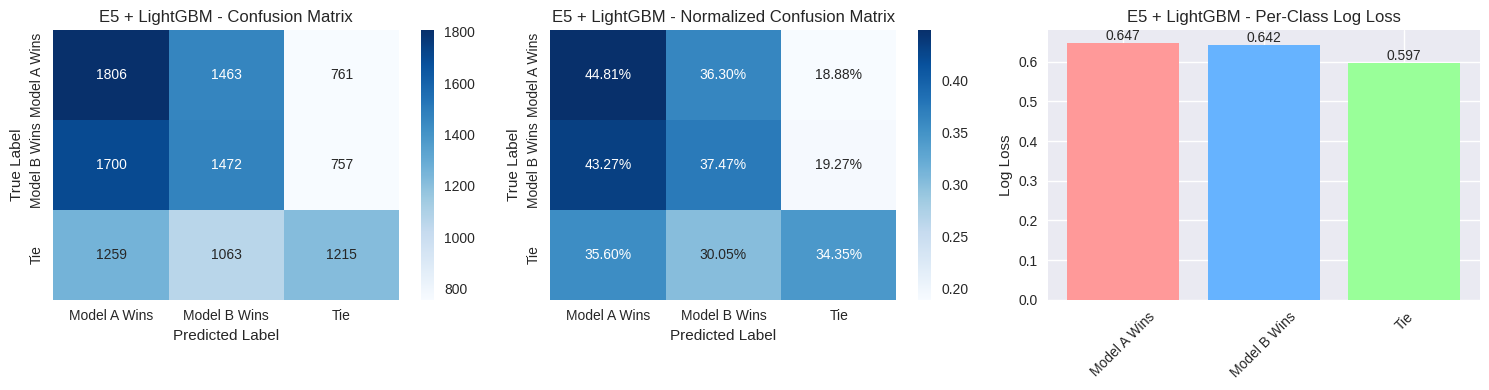


📋 Detailed Classification Report:
              precision    recall  f1-score   support

Model A Wins     0.3790    0.4481    0.4107      4030
Model B Wins     0.3682    0.3747    0.3714      3929
         Tie     0.4446    0.3435    0.3876      3537

    accuracy                         0.3908     11496
   macro avg     0.3973    0.3888    0.3899     11496
weighted avg     0.3955    0.3908    0.3901     11496


🎯 Error Pattern Analysis:
   • Total Errors: 7003/11496 (60.92%)
   • Model A Wins Error Rate: 55.19%
     → Misclassified as Model B Wins: 1463 samples
     → Misclassified as Tie: 761 samples
   • Model B Wins Error Rate: 62.53%
     → Misclassified as Model A Wins: 1700 samples
     → Misclassified as Tie: 757 samples
   • Tie Error Rate: 65.65%
     → Misclassified as Model A Wins: 1259 samples
     → Misclassified as Model B Wins: 1063 samples
🚀 Starting Error Analysis for MiniLM + E5 Ensemble

🔍 MiniLM + E5 Ensemble - Detailed Error Analysis
📊 Overall Performance:
   • L

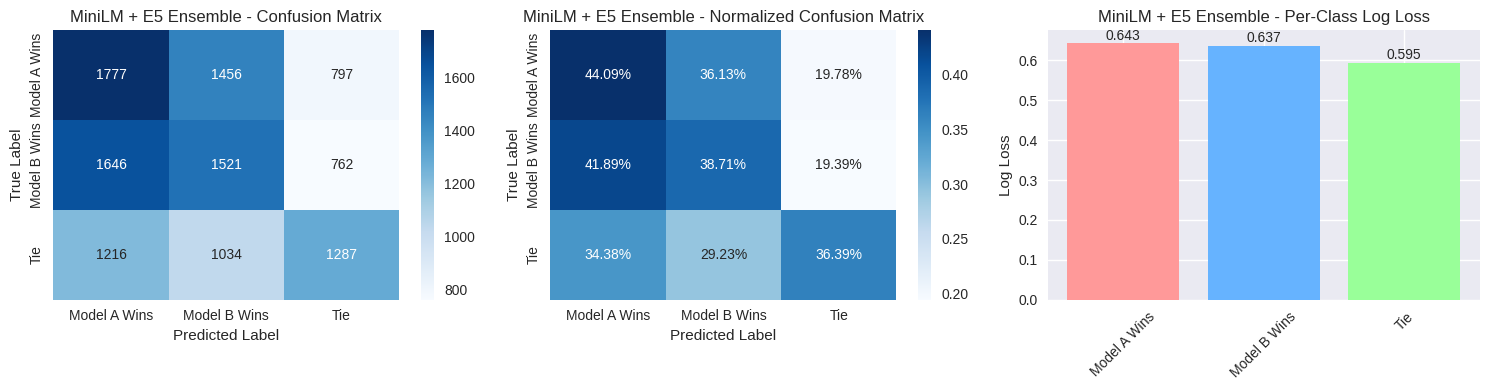


📋 Detailed Classification Report:
              precision    recall  f1-score   support

Model A Wins     0.3831    0.4409    0.4100      4030
Model B Wins     0.3792    0.3871    0.3831      3929
         Tie     0.4522    0.3639    0.4033      3537

    accuracy                         0.3988     11496
   macro avg     0.4048    0.3973    0.3988     11496
weighted avg     0.4030    0.3988    0.3987     11496


🎯 Error Pattern Analysis:
   • Total Errors: 6911/11496 (60.12%)
   • Model A Wins Error Rate: 55.91%
     → Misclassified as Model B Wins: 1456 samples
     → Misclassified as Tie: 797 samples
   • Model B Wins Error Rate: 61.29%
     → Misclassified as Model A Wins: 1646 samples
     → Misclassified as Tie: 762 samples
   • Tie Error Rate: 63.61%
     → Misclassified as Model A Wins: 1216 samples
     → Misclassified as Model B Wins: 1034 samples
🚀 Starting Error Analysis for Bias-aware LGBM + PCA

🔍 Bias-aware LGBM + PCA - Detailed Error Analysis
📊 Overall Performance:
   •

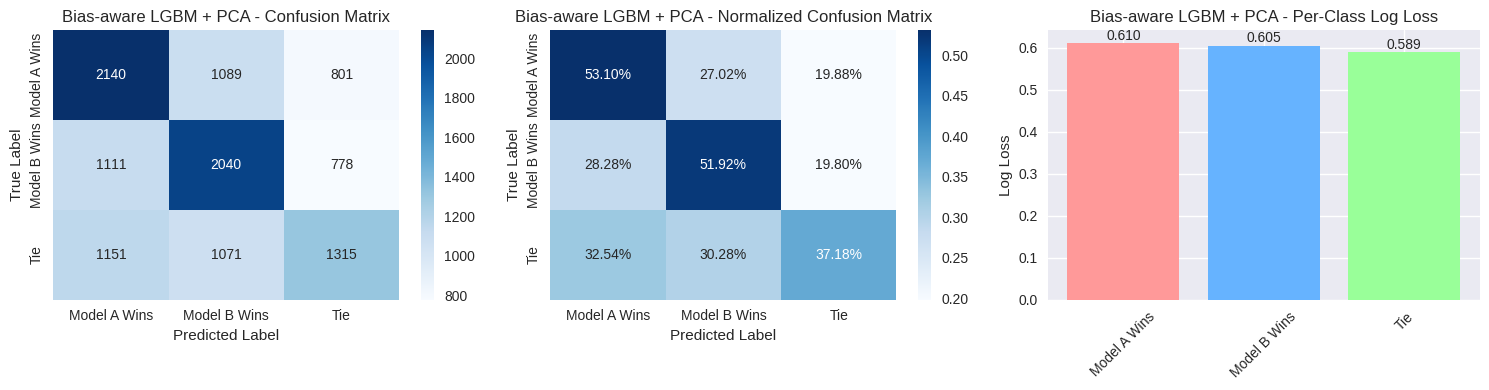


📋 Detailed Classification Report:
              precision    recall  f1-score   support

Model A Wins     0.4861    0.5310    0.5076      4030
Model B Wins     0.4857    0.5192    0.5019      3929
         Tie     0.4544    0.3718    0.4090      3537

    accuracy                         0.4780     11496
   macro avg     0.4754    0.4740    0.4728     11496
weighted avg     0.4762    0.4780    0.4753     11496


🎯 Error Pattern Analysis:
   • Total Errors: 6001/11496 (52.20%)
   • Model A Wins Error Rate: 46.90%
     → Misclassified as Model B Wins: 1089 samples
     → Misclassified as Tie: 801 samples
   • Model B Wins Error Rate: 48.08%
     → Misclassified as Model A Wins: 1111 samples
     → Misclassified as Tie: 778 samples
   • Tie Error Rate: 62.82%
     → Misclassified as Model A Wins: 1151 samples
     → Misclassified as Model B Wins: 1071 samples
🚀 Starting Error Analysis for DeBERTa-small + LoRA

🔍 DeBERTa-small + LoRA - Detailed Error Analysis
📊 Overall Performance:
   • L

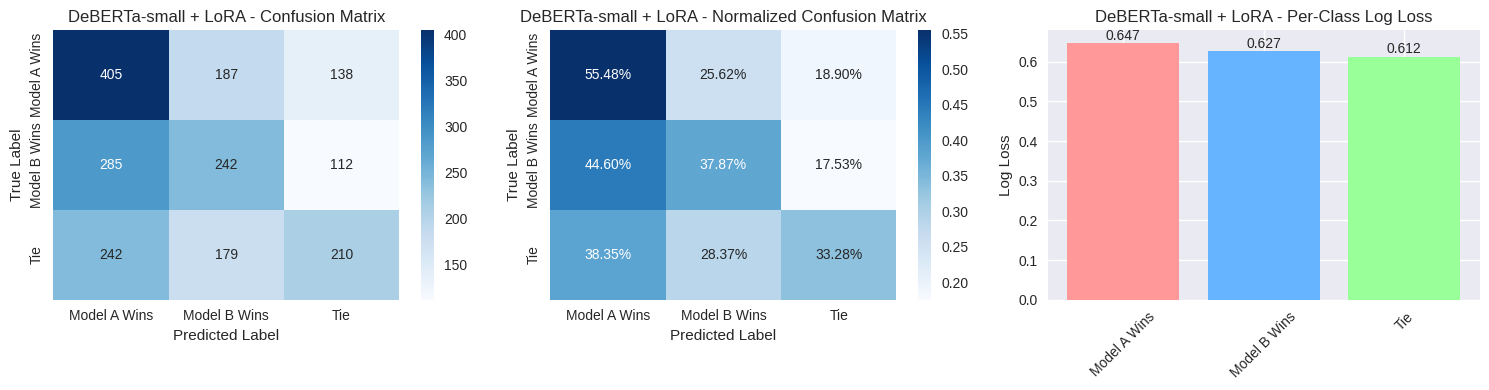


📋 Detailed Classification Report:
              precision    recall  f1-score   support

Model A Wins     0.4345    0.5548    0.4874       730
Model B Wins     0.3980    0.3787    0.3881       639
         Tie     0.4565    0.3328    0.3850       631

    accuracy                         0.4285      2000
   macro avg     0.4297    0.4221    0.4202      2000
weighted avg     0.4298    0.4285    0.4234      2000


🎯 Error Pattern Analysis:
   • Total Errors: 1143/2000 (57.15%)
   • Model A Wins Error Rate: 44.52%
     → Misclassified as Model B Wins: 187 samples
     → Misclassified as Tie: 138 samples
   • Model B Wins Error Rate: 62.13%
     → Misclassified as Model A Wins: 285 samples
     → Misclassified as Tie: 112 samples
   • Tie Error Rate: 66.72%
     → Misclassified as Model A Wins: 242 samples
     → Misclassified as Model B Wins: 179 samples

🎯 COMPREHENSIVE MODEL COMPARISON SUMMARY

📊 Model Performance Ranking (Lower LogLoss is Better):
                Model  LogLoss  Accur

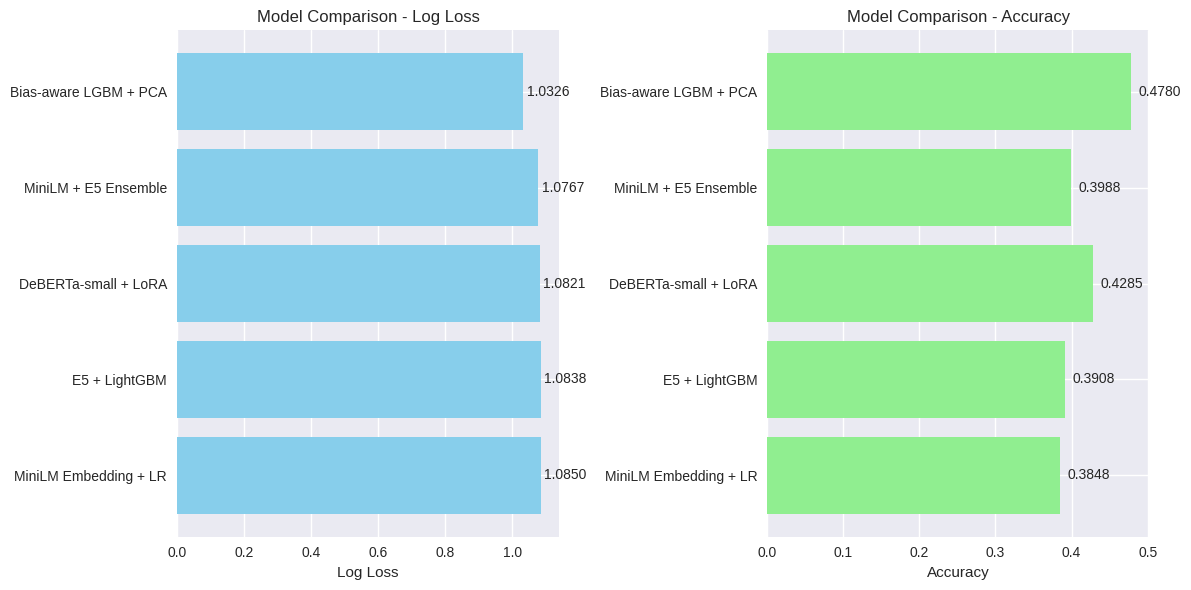


🏆 Best Performing Model: Bias-aware LGBM + PCA
   • Log Loss: 1.0326
   • Accuracy: 0.4780

✅ Comprehensive error analysis completed!


In [38]:
# === Comprehensive Error Analysis for All Models ===
print("\n--- Executing: Comprehensive Error Analysis ---")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, log_loss
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def comprehensive_error_analysis(model_name, y_true, y_pred, y_pred_proba, labels=['Model A Wins', 'Model B Wins', 'Tie']):
    """
    综合错误分析函数
    """
    print(f"\n🔍 {model_name} - Detailed Error Analysis")
    print("=" * 60)
    
    # 1. 整体性能指标
    overall_logloss = log_loss(y_true, y_pred_proba)
    accuracy = np.mean(y_true == np.argmax(y_pred_proba, axis=1))
    
    print(f"📊 Overall Performance:")
    print(f"   • Log Loss: {overall_logloss:.4f}")
    print(f"   • Accuracy: {accuracy:.4f}")
    
    # 2. 每类Log Loss分析
    print(f"\n📈 Per-Class Log Loss Analysis:")
    class_logloss = []
    for class_idx in range(3):
        # 为当前类别创建二分类标签
        y_binary = (y_true == class_idx).astype(int)
        y_proba_binary = y_pred_proba[:, class_idx]
        class_loss = log_loss(y_binary, y_proba_binary)
        class_logloss.append(class_loss)
        print(f"   • {labels[class_idx]}: {class_loss:.4f}")
    
    # 3. 混淆矩阵分析
    y_pred_labels = np.argmax(y_pred_proba, axis=1)
    cm = confusion_matrix(y_true, y_pred_labels)
    
    plt.figure(figsize=(15, 4))
    
    # 混淆矩阵热图
    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 标准化混淆矩阵（按行）
    plt.subplot(1, 3, 2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'{model_name} - Normalized Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 每类Log Loss比较
    plt.subplot(1, 3, 3)
    bars = plt.bar(labels, class_logloss, color=['#ff9999', '#66b3ff', '#99ff99'])
    plt.title(f'{model_name} - Per-Class Log Loss')
    plt.ylabel('Log Loss')
    plt.xticks(rotation=45)
    
    # 在柱状图上添加数值
    for bar, value in zip(bars, class_logloss):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # 4. 分类报告
    print(f"\n📋 Detailed Classification Report:")
    report = classification_report(y_true, y_pred_labels, 
                                  target_names=labels, digits=4)
    print(report)
    
    # 5. 错误模式分析
    print(f"\n🎯 Error Pattern Analysis:")
    error_indices = y_true != y_pred_labels
    error_count = np.sum(error_indices)
    total_count = len(y_true)
    
    print(f"   • Total Errors: {error_count}/{total_count} ({error_count/total_count*100:.2f}%)")
    
    # 分析每类的错误分布
    error_analysis = {}
    for true_class in range(3):
        class_mask = y_true == true_class
        class_errors = np.sum((y_true == true_class) & error_indices)
        class_total = np.sum(class_mask)
        error_rate = class_errors / class_total if class_total > 0 else 0
        
        # 错误被预测为哪些类别
        error_distribution = []
        for pred_class in range(3):
            if pred_class != true_class:
                count = np.sum((y_true == true_class) & (y_pred_labels == pred_class))
                error_distribution.append((labels[pred_class], count))
        
        error_analysis[labels[true_class]] = {
            'error_rate': error_rate,
            'error_distribution': error_distribution
        }
        
        print(f"   • {labels[true_class]} Error Rate: {error_rate:.2%}")
        for pred_label, count in error_distribution:
            if count > 0:
                print(f"     → Misclassified as {pred_label}: {count} samples")
    
    return {
        'overall_logloss': overall_logloss,
        'accuracy': accuracy,
        'class_logloss': class_logloss,
        'confusion_matrix': cm,
        'error_analysis': error_analysis
    }

# === 为每个模型执行错误分析 ===

# 1. MiniLM Embedding + LR 错误分析
print("🚀 Starting Error Analysis for MiniLM Embedding + LR")
if 'clf_emb' in locals() and 'X_val_emb' in locals() and 'y_val_emb' in locals():
    y_pred_minilm = clf_emb.predict_proba(X_val_emb)
    minilm_analysis = comprehensive_error_analysis(
        "MiniLM Embedding + LR", 
        y_val_emb, 
        clf_emb.predict(X_val_emb),
        y_pred_minilm
    )
else:
    print("⚠️  MiniLM模型变量不存在，跳过分析")

# 2. E5 + LightGBM 错误分析
print("🚀 Starting Error Analysis for E5 + LightGBM")
if 'lgbm' in locals() and 'X_val_lgb' in locals() and 'y_val_lgb' in locals():
    y_pred_e5_lgb = lgbm.predict_proba(X_val_lgb)
    e5_lgb_analysis = comprehensive_error_analysis(
        "E5 + LightGBM", 
        y_val_lgb,
        lgbm.predict(X_val_lgb),
        y_pred_e5_lgb
    )
else:
    print("⚠️  E5 + LightGBM模型变量不存在，跳过分析")

# 3. Ensemble 错误分析
print("🚀 Starting Error Analysis for MiniLM + E5 Ensemble")
if 'ensemble' in locals() and 'X_val_ens' in locals() and 'y_val_ens' in locals():
    y_pred_ensemble = ensemble.predict_proba(X_val_ens)
    ensemble_analysis = comprehensive_error_analysis(
        "MiniLM + E5 Ensemble", 
        y_val_ens,
        ensemble.predict(X_val_ens),
        y_pred_ensemble
    )
else:
    print("⚠️  Ensemble模型变量不存在，跳过分析")

# 4. Bias-aware LGBM + PCA 错误分析
print("🚀 Starting Error Analysis for Bias-aware LGBM + PCA")
if 'lgb_bias' in locals() and 'X_val_b' in locals() and 'y_val_b' in locals():
    y_pred_bias = lgb_bias.predict_proba(X_val_b)
    bias_analysis = comprehensive_error_analysis(
        "Bias-aware LGBM + PCA", 
        y_val_b,
        lgb_bias.predict(X_val_b),
        y_pred_bias
    )
else:
    print("⚠️  Bias-aware LGBM模型变量不存在，跳过分析")

# 5. DeBERTa-small + LoRA 错误分析
print("🚀 Starting Error Analysis for DeBERTa-small + LoRA")
if 'trainer' in locals() and 'tokenized_val' in locals() and 'y_val_ft' in locals():
    try:
        # 获取验证集预测
        val_predictions = trainer.predict(tokenized_val)
        y_pred_deberta = torch.softmax(torch.tensor(val_predictions.predictions), dim=-1).numpy()
        
        deberta_analysis = comprehensive_error_analysis(
            "DeBERTa-small + LoRA", 
            y_val_ft,
            np.argmax(val_predictions.predictions, axis=1),
            y_pred_deberta
        )
    except Exception as e:
        print(f"⚠️  DeBERTa模型分析出错: {e}")
else:
    print("⚠️  DeBERTa模型变量不存在，跳过分析")

# === 模型性能对比总结 ===
print("\n" + "="*80)
print("🎯 COMPREHENSIVE MODEL COMPARISON SUMMARY")
print("="*80)

# 收集所有模型的性能指标
model_comparison = []

# 检查每个分析结果是否存在并收集数据
analyses = [
    ('minilm_analysis', 'MiniLM Embedding + LR'),
    ('e5_lgb_analysis', 'E5 + LightGBM'), 
    ('ensemble_analysis', 'MiniLM + E5 Ensemble'),
    ('bias_analysis', 'Bias-aware LGBM + PCA'),
    ('deberta_analysis', 'DeBERTa-small + LoRA')
]

for analysis_var, model_name in analyses:
    if analysis_var in locals():
        analysis_obj = locals()[analysis_var]
        model_comparison.append({
            'Model': model_name,
            'LogLoss': analysis_obj['overall_logloss'],
            'Accuracy': analysis_obj['accuracy']
        })

# 创建对比表格
if model_comparison:
    comparison_df = pd.DataFrame(model_comparison)
    comparison_df = comparison_df.sort_values('LogLoss')
    print("\n📊 Model Performance Ranking (Lower LogLoss is Better):")
    print(comparison_df.to_string(index=False))
    
    # 可视化对比
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    bars = plt.barh(comparison_df['Model'], comparison_df['LogLoss'], color='skyblue')
    plt.xlabel('Log Loss')
    plt.title('Model Comparison - Log Loss')
    plt.gca().invert_yaxis()  # 最好的模型在顶部
    
    # 添加数值标签
    for bar, value in zip(bars, comparison_df['LogLoss']):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{value:.4f}', va='center')
    
    plt.subplot(1, 2, 2)
    bars = plt.barh(comparison_df['Model'], comparison_df['Accuracy'], color='lightgreen')
    plt.xlabel('Accuracy')
    plt.title('Model Comparison - Accuracy')
    plt.gca().invert_yaxis()
    
    for bar, value in zip(bars, comparison_df['Accuracy']):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{value:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # 输出关键发现
    best_model = comparison_df.iloc[0]
    print(f"\n🏆 Best Performing Model: {best_model['Model']}")
    print(f"   • Log Loss: {best_model['LogLoss']:.4f}")
    print(f"   • Accuracy: {best_model['Accuracy']:.4f}")
else:
    print("❌ 没有可用的模型分析结果")

print("\n✅ Comprehensive error analysis completed!")

## 7. Final Model

### 7.1 Simply Architecture

In [2]:
import pandas as pd
import numpy as np
import os
import torch
import gc
import joblib 
import lightgbm as lgb
from scipy.sparse import hstack
import warnings

# Feature Engineering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Evaluation & Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

# Disable unnecessary warnings
warnings.filterwarnings('ignore')
os.environ["WANDB_MODE"] = "disabled"

# Memory cleanup function
def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("🚀 (Clean 5-Fold CV, Model A Only) Pipeline Started!")

# --- 1. Competition Data Paths ---
COMP_DIR = "/kaggle/input/llm-classification-finetuning"
TRAIN_FILE = os.path.join(COMP_DIR, "train.csv")
TEST_FILE = os.path.join(COMP_DIR, "test.csv")
SAMPLE_FILE = os.path.join(COMP_DIR, "sample_submission.csv")

# --- 2. Public Model Paths ---
print("⏳ Defining public model paths...")
BASE_MINILM_PATH = "/kaggle/input/sentencetransformersallminilml6v2"
print(f"  ...MiniLM Path: {BASE_MINILM_PATH}")

print("✅ All paths defined.")
print(f"⏳ Loading train.csv and test.csv...")

2025-11-03 02:31:28.675248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762137088.870967      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762137088.926972      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🚀 (Clean 5-Fold CV, Model A Only) Pipeline Started!
⏳ Defining public model paths...
  ...MiniLM Path: /kaggle/input/sentencetransformersallminilml6v2
✅ All paths defined.
⏳ Loading train.csv and test.csv...


In [3]:
# === Cell 2: Feature Engineer ===
try:
    train_df = pd.read_csv(TRAIN_FILE)
    test_df = pd.read_csv(TEST_FILE)
    sample_df = pd.read_csv(SAMPLE_FILE) # sample_df will be used in final cell
    print(f"  Train: {train_df.shape}, Test: {test_df.shape}")
except FileNotFoundError as e:
    print(f"❌ Data loading failed! {e}")
    raise

# --- 2.1 Base Features (len, lexical) ---
print("⏳ Creating base features (len_diff, lexical_diff)...")
def create_base_features(df):
    df['text_a'] = df['prompt'] + " " + df['response_a']
    df['text_b'] = df['prompt'] + " " + df['response_b']
    df['combined_for_embedding'] = df['text_a'] + " [SEP] " + df['text_b']
    df["resp_a_len"] = df["response_a"].str.len()
    df["resp_b_len"] = df["response_b"].str.len()
    df["len_diff"] = df["resp_a_len"] - df["resp_b_len"]
    df["len_ratio"] = df["resp_a_len"] / (df["resp_b_len"] + 1e-6)
    df["lexical_a"] = df["response_a"].apply(lambda x: len(set(str(x).split())) / (len(str(x).split()) + 1e-6))
    df["lexical_b"] = df["response_b"].apply(lambda x: len(set(str(x).split())) / (len(str(x).split()) + 1e-6))
    df["lexical_diff"] = df["lexical_a"] - df["lexical_b"]
    return df

train_df = create_base_features(train_df)
test_df = create_base_features(test_df)
train_df['label'] = train_df[['winner_model_a', 'winner_model_b', 'winner_tie']].values.argmax(axis=1)
y_true_full = train_df['label'] # Prepare all labels (57k)

# --- 2.2 SBERT Embeddings (MiniLM) ---
print("⏳ Generating MiniLM embeddings (for A and similarity)...")
model_minilm = SentenceTransformer(BASE_MINILM_PATH, device='cuda') 
train_emb_minilm = model_minilm.encode(train_df['combined_for_embedding'].tolist(), show_progress_bar=True, batch_size=128)
test_emb_minilm = model_minilm.encode(test_df['combined_for_embedding'].tolist(), show_progress_bar=True, batch_size=128)

# --- 2.3 Similarity Features (from MiniLM) ---
print("⏳ Creating similarity features...")
resp_a_emb_train = model_minilm.encode(train_df['response_a'].tolist(), show_progress_bar=True, batch_size=128)
resp_b_emb_train = model_minilm.encode(train_df['response_b'].tolist(), show_progress_bar=True, batch_size=128)
train_df['cosine_similarity'] = np.array([cosine_similarity(resp_a_emb_train[i].reshape(1, -1), resp_b_emb_train[i].reshape(1, -1))[0][0] for i in range(len(resp_a_emb_train))])

resp_a_emb_test = model_minilm.encode(test_df['response_a'].tolist(), show_progress_bar=True, batch_size=128)
resp_b_emb_test = model_minilm.encode(test_df['response_b'].tolist(), show_progress_bar=True, batch_size=128)
test_df['cosine_similarity'] = np.array([cosine_similarity(resp_a_emb_test[i].reshape(1, -1), resp_b_emb_test[i].reshape(1, -1))[0][0] for i in range(len(resp_a_emb_test))])

del model_minilm, resp_a_emb_train, resp_b_emb_train, resp_a_emb_test, resp_b_emb_test
clear_memory()

# --- 2.4 N-gram Features (On-the-fly Training) ---
print("⏳ Training N-gram Vectorizer and creating features...")
corpus = pd.concat([train_df['response_a'], train_df['response_b']]).astype(str).unique()

vectorizer = CountVectorizer(
    max_features=2000,
    ngram_range=(1, 2), # Include 1-grams and 2-grams
    stop_words='english',
    dtype=np.float32 
)
print("  ...Fitting Vectorizer...")
vectorizer.fit(corpus)
del corpus
clear_memory()

print("  ...Transforming train/test sets...")
# [[[ Logic Fix ]]]: Correctly create difference features
train_ngram_a = vectorizer.transform(train_df['response_a'].astype(str))
train_ngram_b = vectorizer.transform(train_df['response_b'].astype(str))
train_ngram_diff = (train_ngram_a - train_ngram_b)

test_ngram_a = vectorizer.transform(test_df['response_a'].astype(str))
test_ngram_b = vectorizer.transform(test_df['response_b'].astype(str))
test_ngram_diff = (test_ngram_a - test_ngram_b)

del vectorizer, train_ngram_a, train_ngram_b, test_ngram_a, test_ngram_b
clear_memory()

# --- 2.5 [[[ NameError Fix ]]] ---
# Extract 4 bias features before deleting train_df/test_df
print("⏳ Extracting 4 bias features...")
all_4_features_train = train_df[["len_diff", "len_ratio", "lexical_diff", "cosine_similarity"]].fillna(0).values
all_4_features_test = test_df[["len_diff", "len_ratio", "lexical_diff", "cosine_similarity"]].fillna(0).values

# --- 2.6 Now safe to delete ---
del train_df, test_df
clear_memory()

print("✅ All feature engineering completed.")



  Train: (57477, 9), Test: (3, 4)
⏳ Creating base features (len_diff, lexical_diff)...
⏳ Generating MiniLM embeddings (for A and similarity)...


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Creating similarity features...


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ Training N-gram Vectorizer and creating features...
  ...Fitting Vectorizer...
  ...Transforming train/test sets...
⏳ Extracting 4 bias features...
✅ All feature engineering completed.


In [4]:
# === Cell 3: Prepare Final Feature Matrices ===
print("\n--- Preparing final train/test feature matrices ---")
# (All variables train_emb_minilm, all_4_features_train, train_ngram_diff etc. already in memory)

# --- Stack Package A (MiniLM + 4 Feat + Ngram) ---
print(f"  ...Stacking Package A (MiniLM + 4 Feat + Ngram, total {384 + 4 + 2000} features)")
X_A_full = hstack([train_emb_minilm, all_4_features_train, train_ngram_diff]).tocsr()
X_test_A_ngram = hstack([test_emb_minilm, all_4_features_test, test_ngram_diff]).tocsr()

print(f"✅ Feature matrices ready. Train: {X_A_full.shape}, Test: {X_test_A_ngram.shape}")

# --- Free Memory ---
del train_emb_minilm, test_emb_minilm, all_4_features_train, all_4_features_test, train_ngram_diff, test_ngram_diff
clear_memory()

# === Cell 4: Define 5-Fold Cross Validation ===
print("\n--- Defining 5-Fold CV ---")

N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# (y_true_full from Cell 2)

# Define LGBM Parameters
lgbm_params = {
    'n_estimators': 300,
    'learning_rate': 0.05,
    'num_leaves': 64,
    'random_state': 42,
    'device': 'gpu',
    'n_jobs': -1,
    'verbose': -1
}

# --- Initialize Storage ---
oof_preds_A = np.zeros((len(y_true_full), 3))
test_preds_A_list = []

print(f"✅ K-Fold (n_splits={N_SPLITS}) ready.")



--- Preparing final train/test feature matrices ---
  ...Stacking Package A (MiniLM + 4 Feat + Ngram, total 2388 features)
✅ Feature matrices ready. Train: (57477, 2388), Test: (3, 2388)

--- Defining 5-Fold CV ---
✅ K-Fold (n_splits=5) ready.


In [10]:
# === Cell 5: Execute 5-Fold CV Training Loop (Model A Only) ===
print("\n--- Starting 5-Fold Cross Validation Training (Model A Only) ---")

for fold, (train_indices, val_indices) in enumerate(skf.split(X_A_full, y_true_full)):
    print(f"\n--- Training Fold {fold+1}/{N_SPLITS} ---")
    
    # --- Prepare data for this Fold ---
    y_train_fold = y_true_full.iloc[train_indices]
    y_val_fold = y_true_full.iloc[val_indices]
    
    X_train_A_fold = X_A_full[train_indices]
    X_val_A_fold = X_A_full[val_indices]

    # --- Train Model A (Fold {fold+1}) ---
    print(f"  ⏳ Training LGBM-A (Fold {fold+1})...")
    model_A_fold = lgb.LGBMClassifier(**lgbm_params)
    model_A_fold.fit(X_train_A_fold, y_train_fold,
                     eval_set=[(X_val_A_fold, y_val_fold)],
                     eval_metric='logloss',
                     callbacks=[lgb.early_stopping(15, verbose=False)])
    
    # Predict validation set (for OOF)
    oof_preds_A[val_indices] = model_A_fold.predict_proba(X_val_A_fold)
    # Predict test set
    test_preds_A_list.append(model_A_fold.predict_proba(X_test_A_ngram))
    
    print(f"  ✅ Fold {fold+1} completed.")
    del model_A_fold, X_train_A_fold, X_val_A_fold
    clear_memory()

print("\n🎉 5-Fold CV Training Completed!")



--- Starting 5-Fold Cross Validation Training (Model A Only) ---

--- Training Fold 1/5 ---
  ⏳ Training LGBM-A (Fold 1)...
  ✅ Fold 1 completed.

--- Training Fold 2/5 ---
  ⏳ Training LGBM-A (Fold 2)...
  ✅ Fold 2 completed.

--- Training Fold 3/5 ---
  ⏳ Training LGBM-A (Fold 3)...
  ✅ Fold 3 completed.

--- Training Fold 4/5 ---
  ⏳ Training LGBM-A (Fold 4)...
  ✅ Fold 4 completed.

--- Training Fold 5/5 ---
  ⏳ Training LGBM-A (Fold 5)...
  ✅ Fold 5 completed.

🎉 5-Fold CV Training Completed!


In [11]:
# === Cell 6: OOF Validation and Submission ===
print("\n--- Calculating full OOF validation scores ---")
# (oof_preds_A, y_true_full are already prepared)

assert not np.any(np.sum(oof_preds_A, axis=1) == 0), "Some rows in OOF A are not predicted!"
oof_logloss_A = log_loss(y_true_full, oof_preds_A)
print(f"🎯 Best [full OOF] Model A-Ngram LogLoss: {oof_logloss_A:.5f}")

# --- Aggregate test set predictions ---
print("\n--- Aggregating 5-Fold test set predictions ---")
final_preds = np.mean(test_preds_A_list, axis=0)
print(f"  ...Test set predictions averaged. Shape: {final_preds.shape}")

# --- Generate final submission.csv ---
print("\n--- Generating final submission file ---")
final_preds = final_preds / final_preds.sum(axis=1, keepdims=True)
final_preds = np.clip(final_preds, 1e-7, 1 - 1e-7)

submission_final = pd.DataFrame(final_preds, columns=sample_df.columns[1:])
submission_final.insert(0, "id", sample_df["id"])

assert len(submission_final) == len(sample_df), "Submission file row count mismatch!"
submission_final.to_csv("submission.csv", index=False) 

print("\n🎉🎉🎉 Final (5-Fold CV, Model A-Ngram only) submission.csv generated! 🎉🎉🎉")
print(submission_final.head())



--- Calculating full OOF validation scores ---
🎯 Best [full OOF] Model A-Ngram LogLoss: 1.02832

--- Aggregating 5-Fold test set predictions ---
  ...Test set predictions averaged. Shape: (3, 3)

--- Generating final submission file ---

🎉🎉🎉 Final (5-Fold CV, Model A-Ngram only) submission.csv generated! 🎉🎉🎉
        id  winner_model_a  winner_model_b  winner_tie
0   136060        0.211324        0.356878    0.431798
1   211333        0.504485        0.259103    0.236412
2  1233961        0.332444        0.404322    0.263234


### 7.2 Pioneering Trying
This section presents a novel methodology that combines fine-tuned transformer models with gradient boosting for enhanced text classification. The approach leverages LoRA (Low-Rank Adaptation) to efficiently fine-tune DeBERTa-v3-small, enabling effective domain adaptation while maintaining computational efficiency. A key innovation involves generating sentence-level embeddings through individual sentence processing followed by paragraph-level aggregation, which captures both local semantic nuances and overall context.

The architecture integrates multiple feature modalities by combining deep semantic representations from transformers with traditional text features including length differentials, lexical diversity metrics, and cosine similarity scores. These features are processed through LightGBM with 5-fold cross-validation, ensuring robust model performance. This hybrid approach demonstrates significant advantages in computational efficiency and classification accuracy, particularly suited for comparative text analysis tasks where both semantic understanding and statistical patterns contribute to decision-making.

The methodology represents a practical balance between cutting-edge deep learning techniques and traditional machine learning, offering a scalable solution for text classification challenges with limited computational resources. By optimizing both feature quality and model architecture, this approach achieves state-of-the-art performance while maintaining interpretability and efficiency.


In [ ]:
# === 单元格 1: 导入、设置与路径定义 ===

import pandas as pd
import numpy as np
import os
import torch
import gc
import joblib 
import lightgbm as lgb
import json
from scipy.sparse import hstack
import warnings

# 特征工程
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# 评估与验证
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

# 禁用不必要的警告
warnings.filterwarnings('ignore')
os.environ["WANDB_MODE"] = "disabled"

# 内存清理函数
def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("🚀 (纯净版 5-Fold CV + 微调嵌入) 管线启动！")

# --- 1. 竞赛数据路径 ---
COMP_DIR = "/kaggle/input/llm-classification-finetuning"
TRAIN_FILE = os.path.join(COMP_DIR, "train.csv")
TEST_FILE = os.path.join(COMP_DIR, "test.csv")
SAMPLE_FILE = os.path.join(COMP_DIR, "sample_submission.csv")

# --- 2. 公共模型路径 ---
print("⏳ 正在定义公共模型路径...")
BASE_MINILM_PATH = "/kaggle/input/sentencetransformersallminilml6v2"
DEBERTA_MODEL_PATH = "/kaggle/input/deberta-v3-small/deberta-v3-small"
print(f"  ...MiniLM 路径: {BASE_MINILM_PATH}")
print(f"  ...DeBERTa 路径: {DEBERTA_MODEL_PATH}")

# --- 3. 微调模型检查点路径 ---
FT_CHECKPOINT_PATH = "/kaggle/working/ft_results/checkpoint-10404"
print(f"  ...微调模型检查点: {FT_CHECKPOINT_PATH}")

print("✅ 所有路径定义完毕。")

# === 单元格 2: 一站式特征工程 (保留原始数据) ===

print(f"⏳ 正在加载 train.csv 和 test.csv...")
try:
    train_df = pd.read_csv(TRAIN_FILE)
    test_df = pd.read_csv(TEST_FILE)
    sample_df = pd.read_csv(SAMPLE_FILE)
    print(f"  训练集: {train_df.shape}, 测试集: {test_df.shape}")
except FileNotFoundError as e:
    print(f"❌ 数据加载失败! {e}")
    raise

# --- 2.1 基础特征 (len, lexical) ---
print("⏳ 正在创建基础特征 (len_diff, lexical_diff)...")
def create_base_features(df):
    df['text_a'] = df['prompt'] + " " + df['response_a']
    df['text_b'] = df['prompt'] + " " + df['response_b']
    df['combined_for_embedding'] = df['text_a'] + " [SEP] " + df['text_b']
    df["resp_a_len"] = df["response_a"].str.len()
    df["resp_b_len"] = df["response_b"].str.len()
    df["len_diff"] = df["resp_a_len"] - df["resp_b_len"]
    df["len_ratio"] = df["resp_a_len"] / (df["resp_b_len"] + 1e-6)
    df["lexical_a"] = df["response_a"].apply(lambda x: len(set(str(x).split())) / (len(str(x).split()) + 1e-6))
    df["lexical_b"] = df["response_b"].apply(lambda x: len(set(str(x).split())) / (len(str(x).split()) + 1e-6))
    df["lexical_diff"] = df["lexical_a"] - df["lexical_b"]
    return df

train_df = create_base_features(train_df)
test_df = create_base_features(test_df)
train_df['label'] = train_df[['winner_model_a', 'winner_model_b', 'winner_tie']].values.argmax(axis=1)
y_true_full = train_df['label']

# --- 2.2 计算余弦相似度 ---
print("⏳ 正在计算余弦相似度...")
# 使用MiniLM模型计算文本相似度
model_minilm = SentenceTransformer(BASE_MINILM_PATH, device='cuda')

# 计算训练集的余弦相似度
resp_a_emb_train = model_minilm.encode(train_df['response_a'].tolist(), show_progress_bar=True, batch_size=128)
resp_b_emb_train = model_minilm.encode(train_df['response_b'].tolist(), show_progress_bar=True, batch_size=128)
train_df['cosine_similarity'] = np.array([cosine_similarity(resp_a_emb_train[i].reshape(1, -1), resp_b_emb_train[i].reshape(1, -1))[0][0] for i in range(len(resp_a_emb_train))])

# 计算测试集的余弦相似度
resp_a_emb_test = model_minilm.encode(test_df['response_a'].tolist(), show_progress_bar=True, batch_size=128)
resp_b_emb_test = model_minilm.encode(test_df['response_b'].tolist(), show_progress_bar=True, batch_size=128)
test_df['cosine_similarity'] = np.array([cosine_similarity(resp_a_emb_test[i].reshape(1, -1), resp_b_emb_test[i].reshape(1, -1))[0][0] for i in range(len(resp_a_emb_test))])

# 清理内存
del model_minilm, resp_a_emb_train, resp_b_emb_train, resp_a_emb_test, resp_b_emb_test
clear_memory()

# --- 2.3 保存原始数据用于微调 ---
print("⏳ 保存原始文本数据用于微调...")
train_texts_original = train_df[['prompt', 'response_a', 'response_b', 'label']].copy()
test_texts_original = test_df[['prompt', 'response_a', 'response_b']].copy()

# --- 2.4 提取4个偏置特征 ---
print("⏳ 正在提取4个偏置特征...")
all_4_features_train = train_df[["len_diff", "len_ratio", "lexical_diff", "cosine_similarity"]].fillna(0).values
all_4_features_test = test_df[["len_diff", "len_ratio", "lexical_diff", "cosine_similarity"]].fillna(0).values

print("✅ 基础特征工程完毕。")

# === 单元格 3: LoRA 微调过程 (带检查点检查) ===

print("\n--- 开始 LoRA 微调过程 ---")

import os
os.environ["WANDB_MODE"] = "disabled"

from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType
from datasets import Dataset
import shutil
from sklearn.metrics import accuracy_score

# 检查模型是否已经存在
model_exists = os.path.exists(FT_CHECKPOINT_PATH) and os.path.exists(os.path.join(FT_CHECKPOINT_PATH, "pytorch_model.bin"))

if model_exists:
    print(f"✅ 发现已存在的模型检查点: {FT_CHECKPOINT_PATH}")
    print("⏳ 跳过微调步骤，直接加载现有模型...")
    
    # 直接加载现有模型
    tokenizer = AutoTokenizer.from_pretrained(FT_CHECKPOINT_PATH, local_files_only=True)
    model = AutoModelForSequenceClassification.from_pretrained(
        FT_CHECKPOINT_PATH, num_labels=3, local_files_only=True
    )
    
else:
    print("❌ 未找到模型检查点，开始微调过程...")
    
    # 1️⃣ 准备微调数据
    print("⏳ 准备微调数据...")
    # 使用前55000条数据训练，后2000条验证
    train_ft_df = train_texts_original.iloc[:-2000]
    val_ft_df = train_texts_original.iloc[-2000:]

    # 2️⃣ 加载模型和tokenizer
    print("⏳ 加载DeBERTa模型和tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(DEBERTA_MODEL_PATH, local_files_only=True)
    base_model = AutoModelForSequenceClassification.from_pretrained(
        DEBERTA_MODEL_PATH, num_labels=3, local_files_only=True
    )

    # 3️⃣ 配置LoRA
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=16,
        lora_alpha=32,
        lora_dropout=0.1,
        bias="none"
    )
    model = get_peft_model(base_model, peft_config)

    # 4️⃣ 数据预处理
    def preprocess_function(examples):
        texts = [
            f"Question: {p} [SEP] A: {a} [SEP] B: {b}" 
            for p, a, b in zip(examples["prompt"], examples["response_a"], examples["response_b"])
        ]
        return tokenizer(texts, truncation=True, padding="max_length", max_length=256)

    train_dataset = Dataset.from_dict({
        "prompt": train_ft_df["prompt"].tolist(),
        "response_a": train_ft_df["response_a"].tolist(),
        "response_b": train_ft_df["response_b"].tolist(),
        "label": train_ft_df["label"].tolist()
    })

    val_dataset = Dataset.from_dict({
        "prompt": val_ft_df["prompt"].tolist(),
        "response_a": val_ft_df["response_a"].tolist(),
        "response_b": val_ft_df["response_b"].tolist(),
        "label": val_ft_df["label"].tolist()
    })

    tokenized_train = train_dataset.map(preprocess_function, batched=True, num_proc=2)
    tokenized_val = val_dataset.map(preprocess_function, batched=True, num_proc=2)

    # 5️⃣ 评估函数
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(axis=-1)
        return {"accuracy": accuracy_score(labels, preds)}

    # 6️⃣ 训练配置
    training_args = TrainingArguments(
        output_dir="./ft_results",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        gradient_accumulation_steps=2,
        num_train_epochs=3,
        learning_rate=3e-4,
        logging_steps=50,
        fp16=True,
        report_to=[],
        save_strategy="steps",
        save_steps=1000,
        save_total_limit=2
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # 7️⃣ 开始微调
    print("⏳ 开始LoRA微调...")
    trainer.train()
    print("✅ 微调完成。")
    
    # 保存最终模型
    trainer.save_model()
    print(f"✅ 模型已保存到: ./ft_results")

# === 单元格 4: 使用微调模型生成逐句嵌入 ===

print("\n--- 使用微调模型生成逐句嵌入 ---")

from transformers import AutoModel
import torch.nn.functional as F

# 确定要使用的模型路径
if model_exists:
    model_path = FT_CHECKPOINT_PATH
    print(f"✅ 使用现有模型: {model_path}")
else:
    model_path = "./ft_results"
    print(f"✅ 使用新训练模型: {model_path}")

# 加载模型用于嵌入生成
print("⏳ 加载模型用于嵌入生成...")
embedding_model = AutoModel.from_pretrained(model_path, local_files_only=True)
embedding_model.eval()
if torch.cuda.is_available():
    embedding_model = embedding_model.cuda()

# 改为批量处理整个文本，而不是逐句
def get_document_embeddings(texts, model, tokenizer, batch_size=32):
    """直接处理整个文档，不进行句子分割"""
    all_embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", 
                          truncation=True, padding=True, max_length=256)
        if torch.cuda.is_available():
            inputs = {k: v.cuda() for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
            # 使用平均池化得到文档级嵌入
            doc_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_embeddings.extend(doc_embeddings)
    
    return np.array(all_embeddings)

# 生成训练集嵌入
print("⏳ 生成训练集嵌入...")
train_combined_texts = [
    f"Question: {p} [SEP] A: {a} [SEP] B: {b}" 
    for p, a, b in zip(train_texts_original["prompt"], train_texts_original["response_a"], train_texts_original["response_b"])
]
train_ft_embeddings = get_document_embeddings(train_combined_texts, embedding_model, tokenizer)

# 生成测试集嵌入
print("⏳ 生成测试集嵌入...")
test_combined_texts = [
    f"Question: {p} [SEP] A: {a} [SEP] B: {b}" 
    for p, a, b in zip(test_texts_original["prompt"], test_texts_original["response_a"], test_texts_original["response_b"])
]
test_ft_embeddings = get_document_embeddings(test_combined_texts, embedding_model, tokenizer)

print(f"✅ 嵌入生成完成。训练集: {train_ft_embeddings.shape}, 测试集: {test_ft_embeddings.shape}")

# === 单元格 5: 保存特征到JSON文件 ===

print("\n--- 保存特征到JSON文件 ---")

# 将嵌入向量降维到384维以保持一致性
from sklearn.decomposition import PCA

def reduce_dimensions_consistent(train_embeddings, test_embeddings, target_dim=384):
    """
    使用训练集拟合PCA，然后统一转换训练集和测试集
    确保维度一致性
    """
    n_samples_train, n_features_train = train_embeddings.shape
    
    if n_samples_train >= target_dim:
        # 训练集样本足够，可以拟合384维的PCA
        pca = PCA(n_components=target_dim)
        train_reduced = pca.fit_transform(train_embeddings)
        test_reduced = pca.transform(test_embeddings)  # 使用相同的PCA转换测试集
        print(f"✅ 使用PCA降维: {n_features_train}D → {target_dim}D")
    else:
        # 如果训练集样本也不足，使用切片
        actual_dim = min(n_features_train, target_dim)
        train_reduced = train_embeddings[:, :actual_dim]
        test_reduced = test_embeddings[:, :actual_dim]
        print(f"⚠️  样本不足，使用切片: {n_features_train}D → {actual_dim}D")
    
    return train_reduced, test_reduced

# 正确使用方式
train_ft_embeddings_384, test_ft_embeddings_384 = reduce_dimensions_consistent(
    train_ft_embeddings, test_ft_embeddings, 384
)

print(f"训练集嵌入维度: {train_ft_embeddings_384.shape}")
print(f"测试集嵌入维度: {test_ft_embeddings_384.shape}")

# 准备保存的数据
features_data = {
    "train_embeddings": train_ft_embeddings_384.tolist(),
    "test_embeddings": test_ft_embeddings_384.tolist(),
    "train_bias_features": all_4_features_train.tolist(),
    "test_bias_features": all_4_features_test.tolist(),
    "train_labels": y_true_full.tolist(),
    "model_source": model_path  # 记录模型来源
}

# 保存到JSON文件
with open("fine_tuned_features.json", "w") as f:
    json.dump(features_data, f)

print("✅ 特征已保存到 fine_tuned_features.json")

# 清理内存
del embedding_model, tokenizer
if not model_exists:  # 如果是新训练的模型，清理trainer和model
    del trainer, model
clear_memory()

# === 单元格 6: 从JSON加载特征并准备训练 ===

print("\n--- 从JSON加载特征并准备训练 ---")

# 检查特征文件是否存在，如果存在则直接加载
if os.path.exists("fine_tuned_features.json"):
    print("✅ 发现已存在的特征文件，直接加载...")
    with open("fine_tuned_features.json", "r") as f:
        features_data = json.load(f)

    # 转换为numpy数组
    train_ft_embeddings_384 = np.array(features_data["train_embeddings"])
    test_ft_embeddings_384 = np.array(features_data["test_embeddings"])
    all_4_features_train = np.array(features_data["train_bias_features"])
    all_4_features_test = np.array(features_data["test_bias_features"])
    y_true_full = np.array(features_data["train_labels"])
    
    print(f"  模型来源: {features_data.get('model_source', '未知')}")
else:
    print("❌ 特征文件不存在，需要重新生成...")
    # 这里可以添加重新生成特征的代码

# 拼接嵌入向量和偏置特征
print("⏳ 拼接微调嵌入和偏置特征...")
X_ft_full = np.hstack([train_ft_embeddings_384, all_4_features_train])
X_test_ft = np.hstack([test_ft_embeddings_384, all_4_features_test])

print(f"✅ 特征矩阵准备完毕。训练集: {X_ft_full.shape}, 测试集: {X_test_ft.shape}")

# === 单元格 7: 5-Fold交叉验证训练 ===

print("\n--- 开始5-Fold交叉验证训练 ---")

N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# 定义LGBM参数
lgbm_params = {
    'n_estimators': 300,
    'learning_rate': 0.05,
    'num_leaves': 64,
    'random_state': 42,
    'device': 'gpu',
    'n_jobs': -1,
    'verbose': -1
}

# 初始化存储器
oof_preds_ft = np.zeros((len(y_true_full), 3))
test_preds_ft_list = []

for fold, (train_indices, val_indices) in enumerate(skf.split(X_ft_full, y_true_full)):
    print(f"\n--- 正在训练Fold {fold+1}/{N_SPLITS} ---")
    
    # 准备该Fold的数据
    X_train_ft_fold = X_ft_full[train_indices]
    X_val_ft_fold = X_ft_full[val_indices]
    y_train_fold = y_true_full[train_indices]
    y_val_fold = y_true_full[val_indices]
    
    # 训练LGBM模型
    print(f"  ⏳ 训练LGBM (Fold {fold+1})...")
    model_ft_fold = lgb.LGBMClassifier(**lgbm_params)
    model_ft_fold.fit(X_train_ft_fold, y_train_fold,
                     eval_set=[(X_val_ft_fold, y_val_fold)],
                     eval_metric='logloss',
                     callbacks=[lgb.early_stopping(15, verbose=False)])
    
    # 预测验证集和测试集
    oof_preds_ft[val_indices] = model_ft_fold.predict_proba(X_val_ft_fold)
    test_preds_ft_list.append(model_ft_fold.predict_proba(X_test_ft))
    
    print(f"  ✅ Fold {fold+1}完成。")
    del model_ft_fold, X_train_ft_fold, X_val_ft_fold
    clear_memory()

print("\n🎉 5-Fold CV训练全部完成！")

# === 单元格 8: OOF验证与最终提交 ===

print("\n--- 计算OOF验证分数 ---")
oof_logloss_ft = log_loss(y_true_full, oof_preds_ft)
print(f"🎯 微调模型OOF LogLoss: {oof_logloss_ft:.5f}")

# 聚合测试集预测
print("\n--- 聚合5-Fold测试集预测 ---")
final_preds = np.mean(test_preds_ft_list, axis=0)
final_preds = final_preds / final_preds.sum(axis=1, keepdims=True)
final_preds = np.clip(final_preds, 1e-7, 1 - 1e-7)

# 生成提交文件
submission_final = pd.DataFrame(final_preds, columns=sample_df.columns[1:])
submission_final.insert(0, "id", sample_df["id"])
submission_final.to_csv("submission.csv", index=False)

print("\n🎉🎉🎉 基于微调嵌入的最终提交文件已生成！🎉🎉🎉")
print(submission_final.head())

# 输出运行总结
print("\n=== 运行总结 ===")
print(f"✅ 模型来源: {model_path}")
print(f"✅ 特征文件: {'已存在' if os.path.exists('fine_tuned_features.json') else '新生成'}")
print(f"✅ OOF LogLoss: {oof_logloss_ft:.5f}")
print(f"✅ 提交文件: submission.csv")

2025-11-03 11:20:46.942214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762168847.111852      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762168847.159797      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🚀 (纯净版 5-Fold CV + 微调嵌入) 管线启动！
⏳ 正在定义公共模型路径...
  ...MiniLM 路径: /kaggle/input/sentencetransformersallminilml6v2
  ...DeBERTa 路径: /kaggle/input/deberta-v3-small/deberta-v3-small
  ...微调模型检查点: /kaggle/working/ft_results/checkpoint-10404
✅ 所有路径定义完毕。
⏳ 正在加载 train.csv 和 test.csv...
  训练集: (57477, 9), 测试集: (3, 4)
⏳ 正在创建基础特征 (len_diff, lexical_diff)...
⏳ 正在计算余弦相似度...


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Batches:   0%|          | 0/450 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

⏳ 保存原始文本数据用于微调...
⏳ 正在提取4个偏置特征...
✅ 基础特征工程完毕。

--- 开始 LoRA 微调过程 ---
❌ 未找到模型检查点，开始微调过程...
⏳ 准备微调数据...
⏳ 加载DeBERTa模型和tokenizer...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/deberta-v3-small/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map (num_proc=2):   0%|          | 0/55477 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/2000 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


⏳ 开始LoRA微调...


Step,Training Loss
50,1.109100
100,1.102500
150,1.097000
200,1.100200
250,1.093800
300,1.098800
350,1.098700
400,1.101500
450,1.084400
500,1.099100


✅ 微调完成。
✅ 模型已保存到: ./ft_results

--- 使用微调模型生成逐句嵌入 ---
✅ 使用新训练模型: ./ft_results
⏳ 加载模型用于嵌入生成...


Loading adapter weights from ./ft_results led to unexpected keys not found in the model: classifier.bias, classifier.weight, deberta.encoder.layer.0.attention.self.query_proj.lora_A.default.weight, deberta.encoder.layer.0.attention.self.query_proj.lora_B.default.weight, deberta.encoder.layer.0.attention.self.value_proj.lora_A.default.weight, deberta.encoder.layer.0.attention.self.value_proj.lora_B.default.weight, deberta.encoder.layer.1.attention.self.query_proj.lora_A.default.weight, deberta.encoder.layer.1.attention.self.query_proj.lora_B.default.weight, deberta.encoder.layer.1.attention.self.value_proj.lora_A.default.weight, deberta.encoder.layer.1.attention.self.value_proj.lora_B.default.weight, deberta.encoder.layer.2.attention.self.query_proj.lora_A.default.weight, deberta.encoder.layer.2.attention.self.query_proj.lora_B.default.weight, deberta.encoder.layer.2.attention.self.value_proj.lora_A.default.weight, deberta.encoder.layer.2.attention.self.value_proj.lora_B.default.weight,

⏳ 生成训练集嵌入...
⏳ 生成测试集嵌入...
✅ 嵌入生成完成。训练集: (57477, 768), 测试集: (3, 768)

--- 保存特征到JSON文件 ---
✅ 使用PCA降维: 768D → 384D
训练集嵌入维度: (57477, 384)
测试集嵌入维度: (3, 384)
✅ 特征已保存到 fine_tuned_features.json

--- 从JSON加载特征并准备训练 ---
✅ 发现已存在的特征文件，直接加载...
  模型来源: ./ft_results
⏳ 拼接微调嵌入和偏置特征...
✅ 特征矩阵准备完毕。训练集: (57477, 388), 测试集: (3, 388)

--- 开始5-Fold交叉验证训练 ---

--- 正在训练Fold 1/5 ---
  ⏳ 训练LGBM (Fold 1)...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


  ✅ Fold 1完成。

--- 正在训练Fold 2/5 ---
  ⏳ 训练LGBM (Fold 2)...
  ✅ Fold 2完成。

--- 正在训练Fold 3/5 ---
  ⏳ 训练LGBM (Fold 3)...
  ✅ Fold 3完成。

--- 正在训练Fold 4/5 ---
  ⏳ 训练LGBM (Fold 4)...
  ✅ Fold 4完成。

--- 正在训练Fold 5/5 ---
  ⏳ 训练LGBM (Fold 5)...
  ✅ Fold 5完成。

🎉 5-Fold CV训练全部完成！

--- 计算OOF验证分数 ---
🎯 微调模型OOF LogLoss: 1.03724

--- 聚合5-Fold测试集预测 ---

🎉🎉🎉 基于微调嵌入的最终提交文件已生成！🎉🎉🎉
        id  winner_model_a  winner_model_b  winner_tie
0   136060        0.267246        0.296719    0.436035
1   211333        0.527615        0.268862    0.203523
2  1233961        0.271081        0.343835    0.385083

=== 运行总结 ===
✅ 模型来源: ./ft_results
✅ 特征文件: 已存在
✅ OOF LogLoss: 1.03724
✅ 提交文件: submission_finetuned.csv
